In [40]:
import numpy as np
import pandas as pd
import xgboost
# import numba
# import shap
import matplotlib.pyplot as plt
# import lightgbm as lgb
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report
from sklearn.linear_model import ElasticNetCV, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import QuantileRegressor

In [76]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("model_v2.csv")
computer = [col for col in df.columns if "computer" in col.lower()]
fips = [col for col in df.columns if "fips" in col.lower()]

df = df.drop(computer, axis=1)
df = df.drop(fips, axis=1)
df.columns = [c.replace("[", "").replace("]", "").replace("<","") for c in df.columns]
df.columns = [re.sub(r'[^a-zA-Z0-9]', '', s) for s in df.columns]
print([col for col in df.columns if "computer" in col.lower()])

ok = ["LanguageSpokenatHomeVietnamese2020Estimated", 
 "HealthInsuranceCoveragebyAge65to74yearsNohealthinsurancecoverage2020Estimated", 
 "LanguageSpokenatHomeArabic2020Estimated"]
bad = ["StateWV", "StateUT", "ModerateDays", "StateKS", "LanguageSpokenatHomeChineseinclMandarinCantonese2020Estimated",
 "MedianAQI", "90thPercentileAQI", "EmploymentStatusInlaborforceCivilianlaborforce2020Estimated", "StateOH",
 "StateVT", "StateWI", "StateSC", "StateRI", "StateNY", "StateWY", "StatePR", "GoodDays", "StateMI", "StateNV", "StateHI",
 "StateAL", "StateAZ", "StateCO", "StateCT", "StateDC", "StateDE", "StateFL", "StateGA", "StateID", "StateNM", "StateMA",
 "StateMD", "StateME", "StateMN", "StateMT", "StateNE", "StateNH", "StateNJ", "UnhealthyforSensitiveGroupsDays"]
# df = df.drop(bad, axis=1)
# print(len(set(df.columns)))
# print(len(df.columns))

# df = df.set_index("Name")
deaths = [col for col in df.columns if "covid" in col.lower()]
tot_pop = [col for col in df.columns if "total" in col.lower()][0]
y = df[deaths[0]]
y_cases = df[deaths[1]]
# y = y_cases
# Normalized y
# y_lab = y[labels[0]]
# df = df[df[labels[11]].isna() == False]
df = df[y.isna() == False]
y_lab = y[y.isna() == False]
x = df.drop(deaths, axis=1)
# x = x.drop(tot_pop, axis=1)
bad_col = [c for c in x.columns if x[c].isna().sum() > 10]
x = x.drop(bad_col, axis=1)
x = x.iloc[:,:-11]
print(y_lab.shape)
print(x.shape)

[]
(1015,)
(1015, 140)


In [77]:
x=(x-x.mean())/x.std()

In [78]:
x.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015 entries, 0 to 1014
Data columns (total 140 columns):
 #    Column                                                                Dtype  
---   ------                                                                -----  
 0    TotalPopulation2020Estimated                                          float64
 1    Age5to9years2020Estimated                                             float64
 2    Age10to14years2020Estimated                                           float64
 3    Age15to17years2020Estimated                                           float64
 4    Age18and19years2020Estimated                                          float64
 5    Age20to24years2020Estimated                                           float64
 6    Age25to34years2020Estimated                                           float64
 7    Age35to44years2020Estimated                                           float64
 8    Age45to54years2020Estimated                   

In [79]:
# X_T, X_test, y_T, y_test = train_test_split(x, y_lab, test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(x, y_lab, test_size=0.20, random_state=4)

(array([264., 313., 152.,  58.,  12.,  11.,   0.,   1.,   0.,   1.]),
 array([0.        , 0.00059243, 0.00118486, 0.00177729, 0.00236973,
        0.00296216, 0.00355459, 0.00414702, 0.00473945, 0.00533188,
        0.00592431]),
 <a list of 10 Patch objects>)

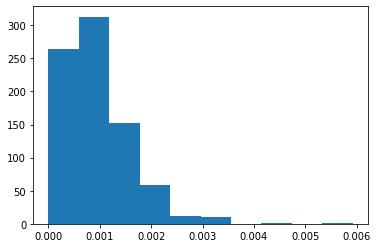

In [80]:
plt.hist(y_train)

In [81]:
lm = LinearRegression().fit(X_train, y_train)
y_pred = lm.predict(X_test)
y_pred_train = lm.predict(X_train)
# The mean squared error
print("Root Mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root Mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.2f" % r2_score(y_train, y_pred_train))

Root Mean squared error: 0.000567125
Root Mean squared error train: 0.000401077
Coefficient of determination: 0.28
Coefficient of determination train: 0.62


In [82]:
# parameters = {
#     'alphas': [[0.1], [0.2], [1.0], [2.0]],
#     'max_iter': [10000, 100000],
#     'l1_ratio': [0.25, 0.3, 0.35, 0.4, 0.45]
# }

# # Initialize the linear regression model with L1 and L2 regularization (Elastic Net)
# enet_model = ElasticNetCV()

# # Use GridSearchCV to find the best hyperparameters for the linear regression model
# clf = GridSearchCV(enet_model, parameters, cv=4, scoring='neg_root_mean_squared_error', n_jobs=8)

# # Fit the model to the training data
# clf.fit(X_train, y_train)

# # Print the best hyperparameters found by GridSearchCV
# print(clf.best_params_)

# y_pred = clf.predict(X_test)
# y_pred_train = clf.predict(X_train)

# # Calculate the mean squared error
# # mse = mean_squared_error(y_test, y_pred)
# # mse_train = mean_squared_error(y_train, y_pred_train)

# # # Calculate the R^2 statistic
# # r2 = r2_score(y_test, y_pred)
# # r2_train = r2_score(y_train, y_pred_train)

# # Print the mean squared error and the R^2 statistic
# print("Root Mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
# print("ROot Mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))

# print("Coefficient of determination: %.4f" % r2_score(y_test, y_pred))
# print("Coefficient of determination train: %.4f" % r2_score(y_train, y_pred_train))

In [83]:
parameters = {
    'alpha': [0.1, 0.2, 0.5, 2.0, 3.0, 5.0, 10.0, 20.0, 50, 100, 200, 300, 500]
}

# Initialize the linear regression model with L1 and L2 regularization (Elastic Net)
ridge = Ridge()

# Use GridSearchCV to find the best hyperparameters for the linear regression model
clf = GridSearchCV(ridge, parameters, cv=4, scoring='neg_root_mean_squared_error', n_jobs=8)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print(clf.best_params_)

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

# Calculate the mean squared error
# mse = mean_squared_error(y_test, y_pred)
# mse_train = mean_squared_error(y_train, y_pred_train)

# # Calculate the R^2 statistic
# r2 = r2_score(y_test, y_pred)
# r2_train = r2_score(y_train, y_pred_train)

# Print the mean squared error and the R^2 statistic
print("Root Mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("ROot Mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))

print("Coefficient of determination: %.4f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.4f" % r2_score(y_train, y_pred_train))

{'alpha': 200}
Root Mean squared error: 0.000537737
ROot Mean squared error train: 0.000425615
Coefficient of determination: 0.3565
Coefficient of determination train: 0.5698


In [62]:
LR_ridge_coeffs = pd.DataFrame(data={'Variable':X_train.columns,'Coeff*E5':clf.best_estimator_.coef_*100000})
LR_ridge_coeffs.to_csv('LR_ridge_coeffs.csv',index=False)

In [50]:
def rmse(x, y):
    return mean_squared_error(x, y, squared=False)
xgb = xgboost.XGBRegressor(colsample_bylevel=0.5, n_estimators=500, max_depth=3, learning_rate=0.1, tree_method="hist", eval_metric=rmse)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)
# The mean squared error
print("Root Mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root Mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.2f" % r2_score(y_train, y_pred_train))

Root Mean squared error: 0.000574540
Root Mean squared error train: 0.000359484
Coefficient of determination: 0.27
Coefficient of determination train: 0.69


In [51]:
svm = SVR(C=0.4, epsilon=0.3, kernel="sigmoid")
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
y_pred_train = svm.predict(X_train)
# The mean squared error
print("Root Mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root Mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.2f" % r2_score(y_train, y_pred_train))

Root Mean squared error: 0.002077899
Root Mean squared error train: 0.002110470
Coefficient of determination: -8.61
Coefficient of determination train: -9.58


In [ ]:
# Create a LightGBM dataset for training
train_data = lgb.Dataset(X_train, label=y_train)

# Create a LightGBM dataset for validation
val_data = lgb.Dataset(X_test, label=y_test)

# Define the parameters for LightGBM
parameters = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 30,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'verbose': 1
}

# Train the model
model = lgb.train(parameters, train_data, valid_sets=val_data, num_boost_round=500, early_stopping_rounds=10)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
# The mean squared error
print("Root Mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root Mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.2f" % r2_score(y_train, y_pred_train))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


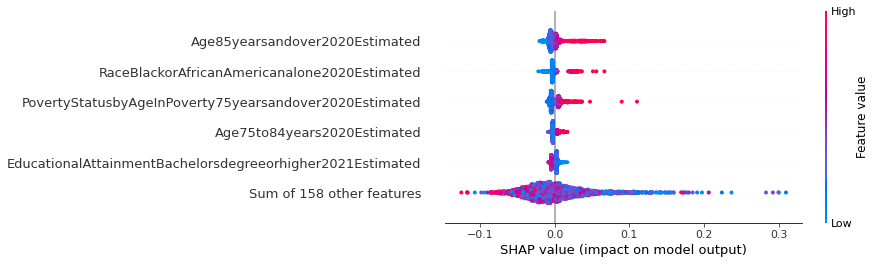

In [ ]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values*100, max_display=6)

In [ ]:
# Create a LightGBM dataset for training
train_data = lgb.Dataset(X_train, label=y_train)

# Create a LightGBM dataset for validation
val_data = lgb.Dataset(X_test, label=y_test)

# Define the parameters for LightGBM
parameters = {
    'num_leaves': [10, 30, 50],
    'learning_rate': [0.01, 0.05],
    'feature_fraction': [0.8, 0.9],
    'bagging_freq': [5, 7]
}
model = lgb.LGBMRegressor(objective="regression", metric="rmse")

clf = GridSearchCV(model, parameters, scoring='neg_root_mean_squared_error', cv=3)

clf.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print(clf.best_params_)

y_pred = clf.predict(X_test)

y_pred_train = clf.predict(X_train)
# Calculate the mean squared error

print("Root mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))

print("Coefficient of determination: %.4f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.4f" % r2_score(y_train, y_pred_train))

In [ ]:
xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=10, tree_method="hist")

# Set up the parameters for the XGBoost model
parameters = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [1, 3, 5],
    'n_estimators': [500, 1000],
    'min_child_weight': [1],
    'colsample_bylevel': [0.5, 1]
}

clf = GridSearchCV(xgb, parameters, scoring='neg_root_mean_squared_error', cv=3)

clf.fit(X_train, y_train)
print(clf.best_estimator_)
# Print the best hyperparameters found by GridSearchCV
print(clf.best_params_)

y_pred = clf.predict(X_test)

y_pred_train = clf.predict(X_train)
# Calculate the mean squared error

print("Root mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))

print("Coefficient of determination: %.4f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.4f" % r2_score(y_train, y_pred_train))

In [11]:
rdf = RandomForestRegressor()

# Set up the parameters for the XGBoost model
parameters = {
    'max_depth': [5,10,15,20,25,30,35,40,50,100],
    'n_estimators': [100]
}

forest = GridSearchCV(rdf, parameters, scoring='neg_root_mean_squared_error', cv=3)

forest.fit(X_train, y_train)
print(forest.best_estimator_)

# Print the best hyperparameters found by GridSearchCV
print(forest.best_params_)

y_pred = forest.predict(X_test)
y_pred_train = forest.predict(X_train)
# Calculate the mean squared error

print("Root mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))

print("Coefficient of determination: %.4f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.4f" % r2_score(y_train, y_pred_train))

RandomForestRegressor(max_depth=30)
{'max_depth': 30, 'n_estimators': 100}
Root mean squared error: 0.000757287
Root mean squared error train: 0.000275513
Coefficient of determination: 0.2362
Coefficient of determination train: 0.8932


In [37]:
param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
    'max_iter': [1000, 10000, 100000]
}

# Define the model
model = QuantileRegressor()
model.fit(X_train, y_train)

# y_pred
# # Create a GridSearchCV object
# clf = GridSearchCV(model, param_grid, cv=3)

# # Train the model
# clf.fit(X_train, y_train)

# # Print the best hyperparameters found by GridSearchCV
# print(clf.best_params_)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Calculate the mean squared error

print("Root mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))

print("Coefficient of determination: %.4f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.4f" % r2_score(y_train, y_pred_train))

KeyboardInterrupt: 